<h1>개인 구글 드라이브와 colab 연동</h1>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


<h1>SIF를 이용한 문장 임베딩</h1>

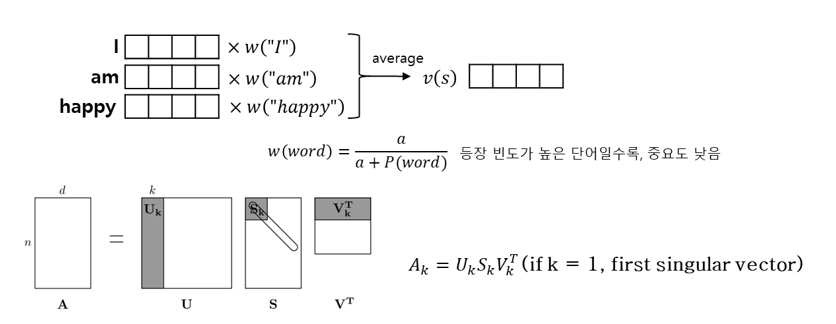

In [7]:
from IPython.display import Image
import os

root_dir = "/gdrive/My Drive/colab/SIF"
Image(os.path.join(root_dir, "SIF.png"))

<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. read_file(file_path)</b>
  "sentences.txt" 파일을 읽기 위한 함수
  
  데이터 예시) "sentences.txt"
    A boy selling cookies to a group of people
    The boys were recently bouncing on the **trampoline**
    A plane is going through routine maintenance
    The green motorcycle is on fire
    The men are too lazy to work
    A woman standing near a car
    There are people near a camera
    The pool is frozen solid
    ...
  
  read_file(file_path)
  args
    file_path : 읽고자 하는 데이터의 경로
  return
    sentences : 문장들을 담고 있는 리스트
    
    출력 예시)
      sentences = [A attractive young blonde nurse talking into a microphone,
                   A baby eats for the second time toda,
                   A baby is having fun at the beach,
                   A band is eating dinner at a dine,
                   A baseball game is taking place,
                   A big tan wet dog in shallow water,
                   
                   ...

                  ]
      

<b>2. read_vocab_files(word_embedding_file_path, word_weight_file_path, rate=1e-3)</b>
  "word_vocab.txt", "word_count.txt" 파일을 읽고 각 단어를 대응하는 임베딩 벡터와 빈도수에
  기반한 가중치로 치환할 딕셔너리를 생성하기 위한 함수
   
  read_vocab_files(word_embedding_file_path, word_weight_file_path, rate=1e-3)
  args
    word_embedding_file_path : 단어와 대응하는 임베딩 벡터를 갖고 있는 어휘 파일 경로
    word_weight_file_path : 단어와 대응하는 빈도수를 갖고 있는 어휘 파일 경로
    rate : 빈도 수에 따른 가중치 계산에 필요한 비율 값
  return
    word2embedding : 단어를 대응하는 임베딩 벡터로 치환하기 위한 딕셔너리
    word2weight : 단어를 대응하는 가중치로 치환하기 위한 딕셔너리

  데이터 예시) "word_vocab.txt"
    a -0.2971 0.0940 -0.0966 -0.3440 -0.1848 ...
    about -0.5353 0.0418 0.1764 -0.2869 -0.1125 ... 
    above -0.6583 0.5911 0.0140 -0.0611 -0.4701 ...
    accordion 0.0540 0.6425 -0.1674 -0.3020 0.0415 ... 
    
    ...

  데이터 예시) "word_count.txt"
    the 167485604
    one 138326283
    zero 126398906
    two 101453018
    
    ...


<b>3. convert_sentences(sentences, word2embedding, word2weight, max_length)</b>
  입력 문장 내부의 단어들을 대응하는 단어 벡터들과 가중치로 치환하기 위한 함수
   
  convert_sentences(sentences, word2embedding, word2weight, max_length)
  args
    sentences : 문장들을 담고 있는 리스트
    word2embedding : 단어를 대응하는 임베딩 벡터로 치환하기 위한 딕셔너리
    word2weight : 단어를 대응하는 가중치로 치환하기 위한 딕셔너리
    max_length : 문장의 최대 길이 (단어 개수)
  return
    sentence_matrices : 단어 벡터들로 구성된 행렬들을 담고 있는 numpy array
    sentence_weights : 문장 내부 단어들의 가중치를 담고 있는 numpy array

  출력 예시)
    문장 : "A attractive young blonde nurse talking into a microphone"

    sentence_matrix : [[-0.2971  0.094  -0.0967 ...  0.0597 -0.2285  0.296 ]
                       [-0.4402  0.0023  0.1178 ... -0.117   0.0396  0.3047]
                       [-0.1035  0.1512  0.3629 ...  0.317  -0.4615 -0.1909]

                       ...

                      ]

    sentence_weight : [0.06, 0.9919, 0.8528, 0.9957, 0.9898, 0.9675, 0.5571, 0.06, 0.9966, 0.0 ]
</pre>

In [8]:
import numpy as np


def read_file(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        # 파일 경로로부터 데이터를 한 줄씩 읽어들인 후에 정렬하여 리스트에 저장
        lines = sorted([line.strip() for line in inFile.readlines()])
    return lines


def read_vocab_files(word_embedding_file_path, word_weight_file_path, rate=1e-3):

    # 단어를 대응하는 임베딩 벡터로 치환하기 위한 딕셔너리
    word2embedding = {}
    for line in read_file(file_path=word_embedding_file_path):
        # 데이터를 공백 단위로 분리 (a -0.2971 0.0940 -0.0966 ...)
        pieces = line.split(" ")
        word, embedding = pieces[0].lower(), [float(temp) for temp in pieces[1:]]
        word2embedding[word] = embedding

    word2weight = {}
    for line in read_file(file_path=word_weight_file_path):
      # 데이터를 공백 단위로 분리 (the 167485604)
        pieces = line.split(" ")
        word, weight = pieces[0].lower(), float(pieces[1])
        word2weight[word] = weight

    # 전체 단어들의 빈도수
    total_weights = np.sum(list(word2weight.values()))
    for word, weight in word2weight.items():
        word2weight[word] = rate / (rate + weight/total_weights)

    return word2embedding, word2weight


def convert_sentences(sentences, word2embedding, word2weight, max_length):
    # sentence_matrices : 단어 벡터들로 구성된 행렬들을 담을 리스트
    # sentence_weights : 문장 내부 단어들의 가중치를 담을 리스트
    sentence_matrices, sentence_weights = [], []

    for sentence in sentences:
        # 문장을 공백 기준으로 분리하여 단어를 추출하고 소문자로 변환하여 저장
        words = [word.lower() for word in sentence.split(" ")]

        # 사전 설정한 문장의 최대 길이에 맞춰 0으로 초기화된 numpy array 생성
        word_embedding_matrix = np.zeros(shape=(max_length, len(list(word2embedding.values())[0])), dtype=float)
        word_weights = np.zeros(shape=(max_length, ), dtype=float)

        for word_index, word in enumerate(words[:max_length]):
            # 각 단어를 대응하는 임베딩 벡터와 가중치로 치환
            word_embedding_matrix[word_index] = word2embedding[word]
            word_weights[word_index] = word2weight[word]

        # 전처리된 데이터를 리스트에 저장
        sentence_matrices.append(word_embedding_matrix)
        sentence_weights.append(word_weights)

    # sentence_matrices : (number_of_sentences, max_length, vector_size)
    # sentence_weights : (number_of_sentences, max_length)
    return np.array(sentence_matrices), np.array(sentence_weights)


<h1>SIF를 이용한 문장 임베딩 벡터 생성</h1>

<pre>
<b>1. get_weighted_vector_of_sentence(sentence_matrices, sentence_weights)</b>
  각 단어의 가중치를 반영한 문장 벡터를 생성하기 위한 함수
  
  get_weighted_vector_of_sentence(sentence_matrices, sentence_weights)
  args
    sentence_matrices : 단어 벡터들로 구성된 행렬들을 담고 있는 numpy array
    sentence_weights : 문장 내부 단어들의 가중치를 담고 있는 numpy array
  return
    sentence_embeddings : 문장 벡터들을 담고 있는 numpy array
    
    문장 : "A attractive young blonde nurse talking into a microphone"

    sentence_matrix : [[-0.2971  0.094  -0.0967 ...  0.0597 -0.2285  0.296 ]
                       [-0.4402  0.0023  0.1178 ... -0.117   0.0396  0.3047]
                       [-0.1035  0.1512  0.3629 ...  0.317  -0.4615 -0.1909]

                       ...

                      ]

    sentence_weight : [0.06, 0.9919, 0.8528, 0.9957, 0.9898, 0.9675, 0.5571, 0.06, 0.9966, 0.0 ]

    sentence_embeddings : [[-0.1025 -0.0313  0.0005 ...  0.101  -0.0113  0.2426]
                           [-0.0353  0.0375 -0.0908 ... -0.1245 -0.0477  0.0764]
                           [-0.0208 -0.0561 -0.0776 ... -0.0262  0.0802 -0.0816]
                            
                           ...

                          ]


<b>2. compute_pc(sentence_embeddings)</b>
  입력 문장 벡터들을 바탕으로 공통 성분을 계산하기 위한 함수
  
  compute_pc(sentence_embeddings)
  args
    sentence_embeddings : 문장 벡터들을 담고 있는 numpy array
  return
    component_ : 전체 문장을 기반으로 계산된 공통 정보 벡터


<b>3. get_sif_embeddings(sentence_matrices, sentence_weights)</b>
  공통 성분이 제거된 문장 임베딩 벡터를 생성하기 위한 함수
  
  get_sif_embeddings(sentence_matrices, sentence_weights)
  args
    sentence_matrices : 단어 벡터들로 구성된 행렬들을 담고 있는 numpy array
    sentence_weights : 문장 내부 단어들의 가중치를 담고 있는 numpy array
  return
    sentence_embeddings : SIF를 이용하여 생성된 문장 벡터들을 담고 있는 numpy array
</pre>


In [9]:
import numpy as np
from sklearn.decomposition import TruncatedSVD


def get_weighted_vector_of_sentence(sentence_matrices, sentence_weights):
    # sentence_matrices : (number_of_sentences, max_length, vector_size)
    # sentence_weights : (number_of_sentences, max_length)

    number_of_sentences, vector_size = sentence_matrices.shape[0], sentence_matrices.shape[2]
    sentence_embeddings = np.zeros(shape=(number_of_sentences, vector_size), dtype=float)

    for sentence_index in range(number_of_sentences):
        # sentence_matrix : (max_length, vector_size)
        sentence_matrix = sentence_matrices[sentence_index]
        # sentence_weight : (1, max_length)
        sentence_weight = np.expand_dims(sentence_weights[sentence_index], axis=0)

        # 평균을 구할 때, 문장의 최대 길이가 아니라 각 문장의 단어 개수에 맞춰 나눠줌
        sentence_embeddings[sentence_index] = sentence_weight.dot(sentence_matrix) / np.count_nonzero(sentence_weight)

    # sentence_embeddings : (number_of_sentences, vector_size)
    return sentence_embeddings


def compute_pc(sentence_embeddings):
    svd = TruncatedSVD(n_components=1, n_iter=7)
    svd.fit(sentence_embeddings)
    return svd.components_


def get_sif_embeddings(sentence_matrices, sentence_weights):
    sentence_embeddings = get_weighted_vector_of_sentence(sentence_matrices=sentence_matrices,
                                                          sentence_weights=sentence_weights)

    pc = compute_pc(sentence_embeddings=sentence_embeddings)
    sentence_embeddings = sentence_embeddings - sentence_embeddings.dot(pc.transpose()) * pc

    return sentence_embeddings

In [10]:
import os
import numpy as np


def cos_sim(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))


if __name__ == "__main__":
    root_dir = "/gdrive/MyDrive/colab/SIF"

    # 어휘 딕셔너리, 가중치 딕셔너리 생성
    word2embedding, word2weight = read_vocab_files(word_embedding_file_path=os.path.join(root_dir, "word_vocab.txt"),
                                                   word_weight_file_path=os.path.join(root_dir, "word_count.txt"))
    
    # 입력 데이터 읽기
    sentences = read_file(file_path=os.path.join(root_dir, "sentences.txt"))

    # 입력 문장 내부의 단어들을 대응하는 단어 벡터들과 가중치로 치환
    sentence_matrices, sentence_weights = convert_sentences(sentences=sentences,
                                                            word2embedding=word2embedding,
                                                            word2weight=word2weight,
                                                            max_length=10)

    # 문장 임베딩 벡터 생성
    sentence_embeddings = get_sif_embeddings(sentence_matrices=sentence_matrices, sentence_weights=sentence_weights)

    # 문장쌍 사이의 코사인 유사도를 계산하여 딕셔너리에 저장
    sim2sentence_pair = {}
    for index_1 in range(len(sentence_embeddings)):
        for index_2 in range(len(sentence_embeddings)):
            if(index_2 > index_1):
                sim = cos_sim(sentence_embeddings[index_1], sentence_embeddings[index_2])
                sim2sentence_pair[sim] = (sentences[index_1], sentences[index_2])

    # 유사도 상위 10개의 문장쌍 추출
    top_10_sim = sorted(list(sim2sentence_pair.keys()), reverse=True)[:10]

    for sim in top_10_sim:
        sentence_1, sentence_2 = sim2sentence_pair[sim]
        print("{} : \"{}\" and \"{}\"".format(round(sim, 4), sentence_1, sentence_2))

    print()

    # 유사도 하위 10개의 문장쌍 추출
    bottom_10_sim = sorted(list(sim2sentence_pair.keys()), reverse=False)[:10]
    for sim in bottom_10_sim:
        sentence_1, sentence_2 = sim2sentence_pair[sim]
        print("{} : \"{}\" and \"{}\"".format(round(sim, 4), sentence_1, sentence_2))


0.8552 : "A boy is playing tennis with a partner" and "Man playing tennis with friend"
0.8488 : "A person playing the guitar" and "two people play guitar"
0.8485 : "The men are riding bikes in the street" and "Two men are riding scooters on the road"
0.8276 : "The men are playing guitar" and "two people play guitar"
0.8259 : "She is wearing clothes" and "The woman is wearing lots of clothing"
0.8223 : "A boy slides down a slide with his legs apart" and "A girl slides down a slide"
0.8086 : "A couple are sitting at their table eating dinner" and "Couple sitting down to eat dinner together"
0.8046 : "A boy riding his skateboard on the walkway" and "A man is riding a skateboard"
0.8039 : "A man is surfing on the ocean" and "Male surfing in the ocean"
0.8004 : "Everybody is wearing formal clothes" and "She is wearing clothes"

-0.4453 : "A woman standing near a car" and "The guys are all dancing"
-0.444 : "A old man on a bicycle riding through the park" and "The women are not talking to ea